# Fit Series function 

In [1]:
%pylab inline

from pathlib import Path

import h5py
import numpy as np
from isingchat import style
from isingchat.io import read_ising_config
from matplotlib import pyplot, rcParams
from matplotlib.axes import Axes, GridSpec
from matplotlib.figure import Figure
from ruamel.yaml import YAML
from scipy import interpolate as interp
from scipy.optimize import curve_fit
from scipy.optimize import least_squares, differential_evolution, minimize
from scipy.signal import savgol_filter
import pandas as pd
import json

import os
import re

yaml = YAML()

Populating the interactive namespace from numpy and matplotlib


## Model
El modelo a utilizar es:
$$ \frac{J}{k_BT} = a_1 \left(\frac{1}{series(n_v,p,z=1,a=a_2)}\right)$$ 
con
$$ series(n_v,p,z,a) = \sum_{i=0}^{n_v-1} \frac{z^i}{(i+a)^p}  $$ 

In [26]:
def serie_divergente(n: int,p: float, z: float=1, a: float=1):
    res = 0
    for i in np.arange(0,n,1):
        res = res + z**i/((i+a)**p)
    return res


def model_function(x: float,coefs):
    """x = 1/nv"""
    a1,a2 = coefs
    return a1*(1/serie_divergente(1/x,p,z=1,a=a2))


def get_extrapol_function(model_function, coefs):
    def extrapol_funct(x):
        return model_function(x, coefs)
    return extrapol_funct


def residuals_func(coefs,x,fi,fi_err=None,rescale_incert=100):
    """Calculate the residuals for the least squares minimization routine.
    
    This function returns a value with the difference between the expected value
    of the model, which we set to zero for all x and y, and the predictions of the
    model.
    Args:
        coefs: Tuple: Parameters to be adjusted of the model
        x: float: Independent variable
        fi: float: Experimental value to adjust, also call y_i
        fi_err: Error for the experimental value, also call y_err_i
    Returns:
        residuals: float: Difference of the model evaluation and expected value
    """
    # We want the model to be almost zero, i.e., that the coefficients and data
    # satisfy the conic equation.
    if fi_err is not None:
        residuals = (fi - model_function(
            x,
            coefs
        )) / (fi_err*rescale_incert)
        
        return residuals
    else:
        residuals = fi - model_function(
            x,
            coefs
        )
        
        return residuals


def get_residuals_func_sum_sqr(x_data,y_data,y_data_err=None,rescale_err=100):
    def residuals_func_sum_sqr(coefs):
        """Calculate the sum of the squared residuals."""
        result = 0
        num_el = len(x_data)
        for index in range(num_el):
            if y_data_err is not None:
                result = result + residuals_func(coefs,x_data[index],y_data[index],y_data_err[index],rescale_err)**2
            else:
                result = result + residuals_func(coefs,x_data[index],y_data[index])**2
        return result

    return residuals_func_sum_sqr

## Read files

In [49]:
data_path = Path("../../data/regular/finite-size/").resolve()
file = 'finite_all_inv_Tc.csv'
df_all_tc = pd.read_csv(os.path.join(data_path,file))
# get uncert inv_temp
file_err = 'finite_all_inv_Tc_uncertainty.csv'
df_all_tc_err = pd.read_csv(os.path.join(data_path,file_err))

In [50]:
df_all_tc = df_all_tc.drop([0,0,0])
df_all_tc

,1/nv,P1.0,P1.05,P1.1,P1.2,P1.3,P1.4,P1.5,P1.6,P1.7,P1.8,P1.9,P2.0
1,0.333333,0.474172,0.479616,0.485186,0.495462,0.505744,0.516007,0.525276,0.534884,0.543836,0.552571,0.560976,0.569244
2,0.250000,0.406877,0.414960,0.423065,0.438941,0.454636,0.469980,0.484784,0.499695,0.514192,0.528122,0.541821,0.555194
3,0.200000,0.363846,0.373370,0.382903,0.401845,0.420934,0.439931,0.458557,0.476878,0.495042,0.512840,0.530448,0.547399
4,0.166667,0.333171,0.343745,0.354152,0.375527,0.396667,0.418225,0.439601,0.460725,0.481590,0.502270,0.522727,0.542827
5,0.142857,0.310034,0.321274,0.332413,0.355228,0.378443,0.401569,0.424909,0.448019,0.471496,0.494206,0.517180,0.539323
6,0.125000,0.291782,0.303439,0.315214,0.339160,0.363620,0.388241,0.413201,0.438283,0.463279,0.488020,0.512904,0.537341
7,0.111111,0.276996,0.289043,0.301251,0.326111,0.351386,0.377466,0.403509,0.430223,0.456767,0.483182,0.509838,0.535864
8,0.100000,0.264710,0.276865,0.289472,0.315044,0.341337,0.368199,0.395594,0.423065,0.451129,0.479223,0.507185,0.534884
9,0.090909,0.254111,0.266597,0.279344,0.305565,0.332500,0.360230,0.388600,0.417391,0.446461,0.475525,0.504973,0.534120
10,0.083333,0.245040,0.257703,0.270612,0.297316,0.324907,0.353301,0.382481,0.412221,0.442279,0.472541,0.502984,0.533616


In [113]:
# with error
df_params = pd.DataFrame(index=["a1","a2","a1_err","a2_err"])
df_extrapol_val = pd.DataFrame(index=["infty","infty_err"])

-------------------------------
1.0
-------------------------------
rescale_incert: 2221.6971268404623
      fun: 0.002989291581794591
 hess_inv: array([[  8.81577541, -65.70192225],
       [-65.70192225, 495.3835838 ]])
      jac: array([-1.36607559e-06, -1.88330887e-07])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 5
     njev: 10
   status: 0
  success: True
        x: array([0.48349181, 2.41066797])


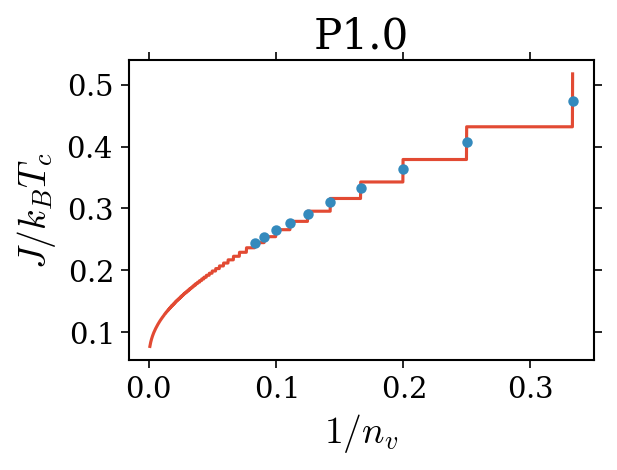

---------------------------------------------
coefs:[0.48349181 2.41066797]
---------------------------------------------
min:0.0773428235602172 at 0.001
fit at 1/nv=1: 1.1655382187394516


Uncertainty: [0.054111944897373324, 0.40563338357043843]
-------------------------------
1.05
-------------------------------
rescale_incert: 2109.8067549885404
      fun: 0.002758575220505919
 hess_inv: array([[  7.38312068, -48.59312689],
       [-48.59312689, 324.26362121]])
      jac: array([6.35118340e-06, 1.42736826e-06])
  message: 'Optimization terminated successfully.'
     nfev: 39
      nit: 9
     njev: 13
   status: 0
  success: True
        x: array([0.48719556, 2.25309526])


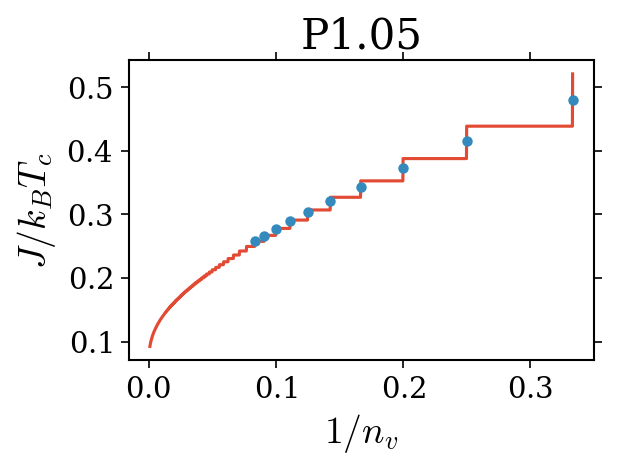

---------------------------------------------
coefs:[0.48719556 2.25309526]
---------------------------------------------
min:0.09234855063476027 at 0.001
fit at 1/nv=1: 1.1431990335807902


Uncertainty: [0.047570875485664944, 0.31526101890539004]
-------------------------------
1.1
-------------------------------
rescale_incert: 2006.057173824677
      fun: 0.00255111889290235
 hess_inv: array([[  7.61083521, -44.91519127],
       [-44.91519127, 268.55111521]])
      jac: array([-1.77882612e-07, -1.00611942e-07])
  message: 'Optimization terminated successfully.'
     nfev: 45
      nit: 11
     njev: 15
   status: 0
  success: True
        x: array([0.49089301, 2.11916464])


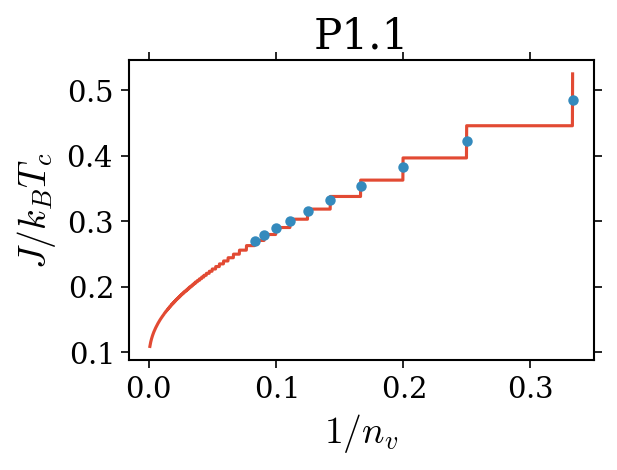

---------------------------------------------
coefs:[0.49089301 2.11916464]
---------------------------------------------
min:0.1090191163261706 at 0.001
fit at 1/nv=1: 1.1214192631212885


Uncertainty: [0.04644727654272061, 0.27590373194785833]
-------------------------------
1.2
-------------------------------
rescale_incert: 1821.3913883345724
      fun: 0.0021084453654193398
 hess_inv: array([[  9.36979586, -44.30466775],
       [-44.30466775, 211.56698001]])
      jac: array([8.35279934e-08, 2.04017852e-08])
  message: 'Optimization terminated successfully.'
     nfev: 63
      nit: 15
     njev: 21
   status: 0
  success: True
        x: array([0.50160838, 1.88942301])


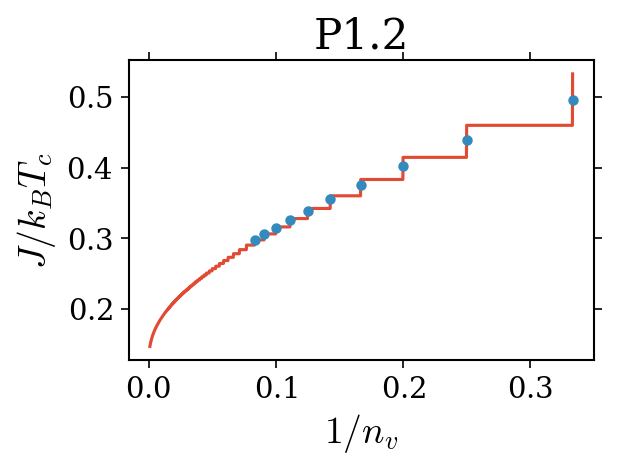

---------------------------------------------
coefs:[0.50160838 1.88942301]
---------------------------------------------
min:0.14736235693410776 at 0.001
fit at 1/nv=1: 1.0763656349727895


Uncertainty: [0.04685166029080171, 0.2226300914271651]
-------------------------------
1.3
-------------------------------
rescale_incert: 1659.945911015165
      fun: 0.0017143835494186942
 hess_inv: array([[ 10.48086707, -40.02935519],
       [-40.02935519, 154.16400045]])
      jac: array([-4.32225352e-06, -1.07704545e-06])
  message: 'Optimization terminated successfully.'
     nfev: 63
      nit: 14
     njev: 21
   status: 0
  success: True
        x: array([0.51528417, 1.70789037])


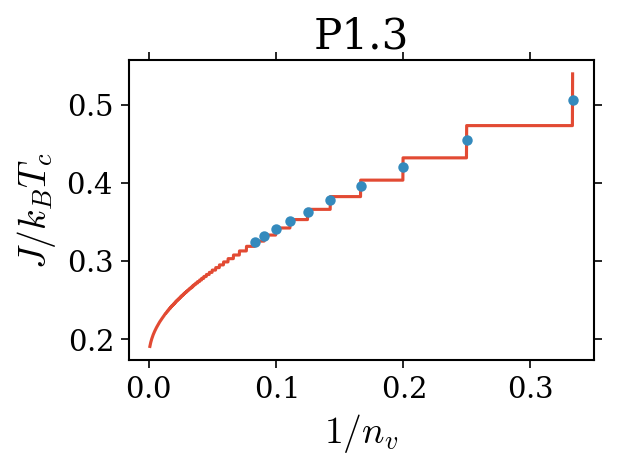

---------------------------------------------
coefs:[0.51528417 1.70789037]
---------------------------------------------
min:0.19090770645122096 at 0.001
fit at 1/nv=1: 1.0333436799635083


Uncertainty: [0.04468187065363055, 0.17136582904515332]
-------------------------------
1.4
-------------------------------
rescale_incert: 1519.6777425225523
      fun: 0.0013804046693546537
 hess_inv: array([[ 12.30738841, -37.78538652],
       [-37.78538652, 116.84120305]])
      jac: array([-8.03860894e-06, -2.07395351e-06])
  message: 'Optimization terminated successfully.'
     nfev: 72
      nit: 18
     njev: 24
   status: 0
  success: True
        x: array([0.53537633, 1.55229995])


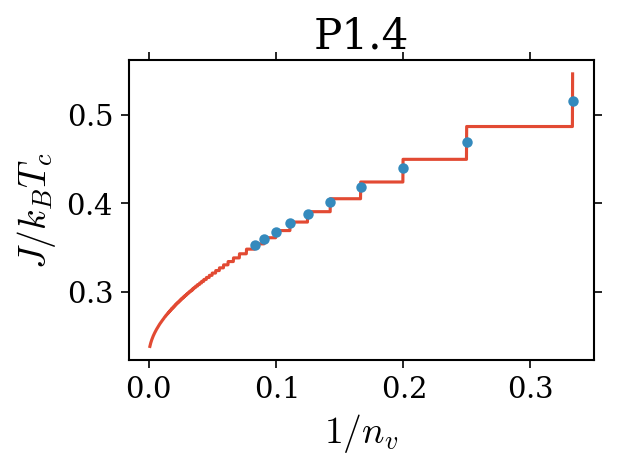

---------------------------------------------
coefs:[0.53537633 1.55229995]
---------------------------------------------
min:0.23816327026459694 at 0.001
fit at 1/nv=1: 0.9908891496832892


Uncertainty: [0.04344751167262418, 0.13386898332050262]
-------------------------------
1.5
-------------------------------
rescale_incert: 1398.7296121134943
      fun: 0.001054378927957595
 hess_inv: array([[ 16.97299326, -40.31738246],
       [-40.31738246,  96.25649108]])
      jac: array([-1.44063961e-09, -1.74622983e-10])
  message: 'Optimization terminated successfully.'
     nfev: 87
      nit: 21
     njev: 29
   status: 0
  success: True
        x: array([0.56843648, 1.40396068])


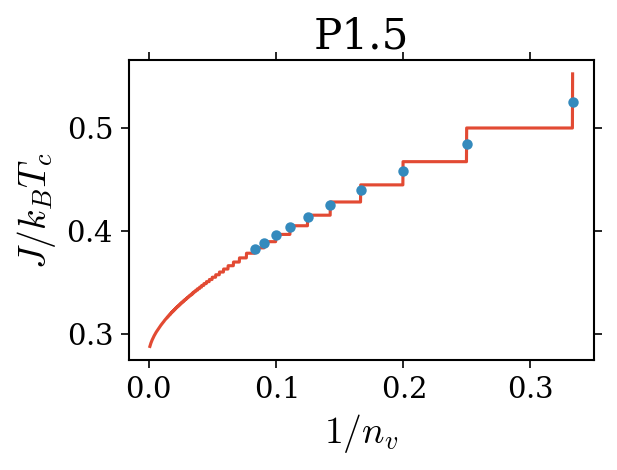

---------------------------------------------
coefs:[0.56843648 1.40396068]
---------------------------------------------
min:0.2877259905028568 at 0.001
fit at 1/nv=1: 0.9456150179634871


Uncertainty: [0.044591935539908076, 0.1061920774816334]
-------------------------------
1.6
-------------------------------
rescale_incert: 1293.3200344615634
      fun: 0.0008013316171852032
 hess_inv: array([[ 24.01156566, -43.70384594],
       [-43.70384594,  79.82475892]])
      jac: array([-3.53481300e-06, -9.67840606e-07])
  message: 'Optimization terminated successfully.'
     nfev: 87
      nit: 22
     njev: 29
   status: 0
  success: True
        x: array([0.61588475, 1.26906921])


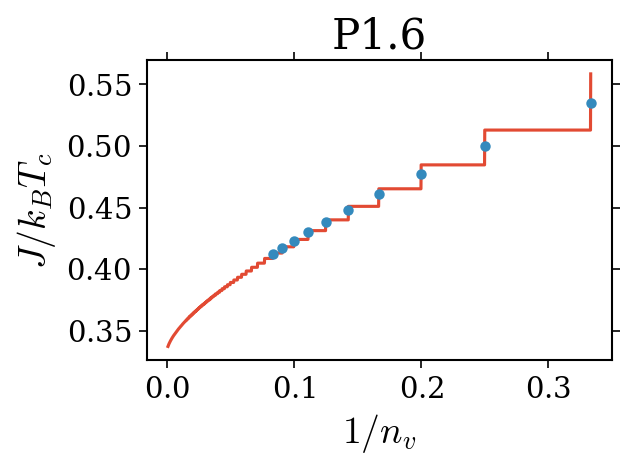

---------------------------------------------
coefs:[0.61588475 1.26906921]
---------------------------------------------
min:0.33725420632709013 at 0.001
fit at 1/nv=1: 0.9017288091539564


Uncertainty: [0.0462375830110468, 0.08430506980960839]
-------------------------------
1.7
-------------------------------
rescale_incert: 1200.1524756762851
      fun: 0.0005688143087645185
 hess_inv: array([[ 40.86228379, -53.41355289],
       [-53.41355289,  69.9788264 ]])
      jac: array([7.74355431e-06, 6.17200567e-06])
  message: 'Optimization terminated successfully.'
     nfev: 117
      nit: 32
     njev: 39
   status: 0
  success: True
        x: array([0.69320026, 1.13164068])


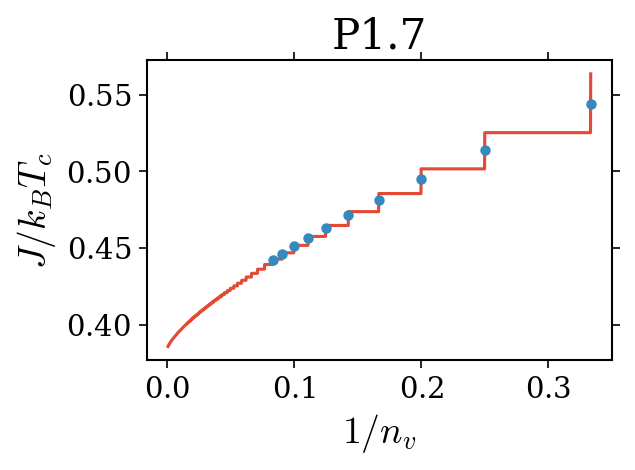

---------------------------------------------
coefs:[0.69320026 1.13164068]
---------------------------------------------
min:0.3859888740978334 at 0.001
fit at 1/nv=1: 0.8553881897487121


Uncertainty: [0.050818906926176605, 0.06650393285292935]
-------------------------------
1.8
-------------------------------
rescale_incert: 1118.2983003441334
      fun: 0.00038982610820893635
 hess_inv: array([[ 98.02105412, -86.58918622],
       [-86.58918622,  76.63129007]])
      jac: array([3.36301673e-06, 3.96022733e-06])
  message: 'Optimization terminated successfully.'
     nfev: 138
      nit: 40
     njev: 46
   status: 0
  success: True
        x: array([0.82311059, 0.98891258])


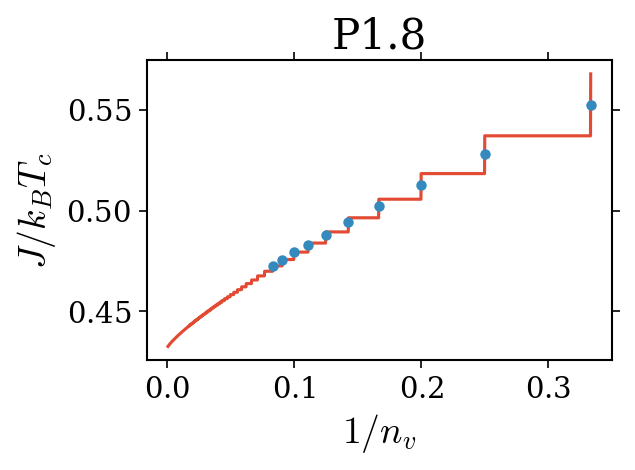

---------------------------------------------
coefs:[0.82311059 0.98891258]
---------------------------------------------
min:0.4326497229016588 at 0.001
fit at 1/nv=1: 0.8067563841181736


Uncertainty: [0.06515892200482754, 0.05761257344776555]
-------------------------------
1.9
-------------------------------
rescale_incert: 1045.285569827966
      fun: 0.0002466031675593549
 hess_inv: array([[ 278.35472326, -141.46029331],
       [-141.46029331,   71.94815996]])
      jac: array([-2.65292329e-07, -4.84262273e-07])
  message: 'Optimization terminated successfully.'
     nfev: 195
      nit: 46
     njev: 65
   status: 0
  success: True
        x: array([1.07731936, 0.82860705])


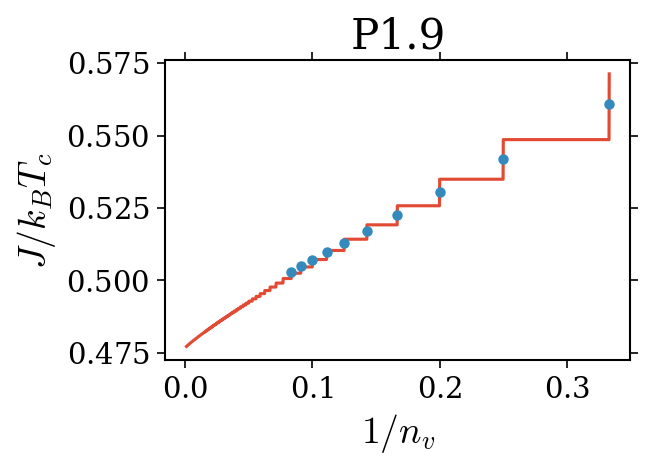

---------------------------------------------
coefs:[1.07731936 0.82860705]
---------------------------------------------
min:0.47719989272844965 at 0.001
fit at 1/nv=1: 0.7537144669175412


Uncertainty: [0.08733279672900458, 0.044400505684322814]
-------------------------------
2.0
-------------------------------
rescale_incert: 981.5501023056707
      fun: 0.00015178683269112948
 hess_inv: array([[1786.84950631, -398.30237408],
       [-398.30237408,   88.80907553]])
      jac: array([-1.41888995e-06, -6.42321174e-06])
  message: 'Optimization terminated successfully.'
     nfev: 249
      nit: 65
     njev: 83
   status: 0
  success: True
        x: array([1.69705549, 0.6399722 ])


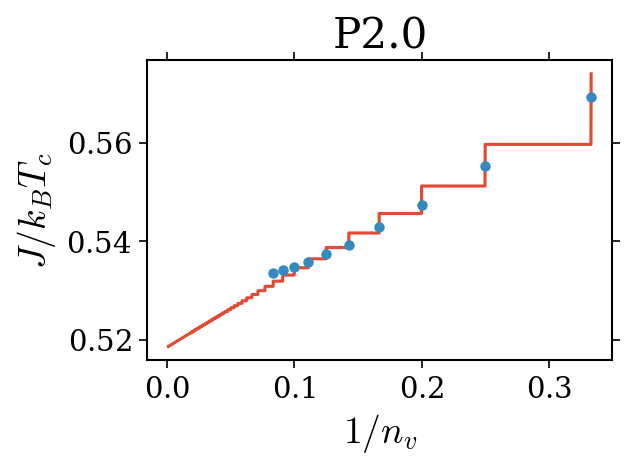

---------------------------------------------
coefs:[1.69705549 0.6399722 ]
---------------------------------------------
min:0.5186935879323538 at 0.001
fit at 1/nv=1: 0.6950535402991517


Uncertainty: [0.17359602755886774, 0.03870120338233411]


In [121]:
epsilon = 0.0001
min_nv = 3
chi_squared = False
if min_nv == 1:
    nv_ind = 0
else:
    nv_ind = min_nv-3
COLUMNS = ["P1.0","P1.05","P1.1","P1.2","P1.3","P1.4","P1.5","P1.6","P1.7","P1.8","P1.9","P2.0"]
# COLUMNS = ["P1.05"]
path_save_graph = Path("../../graphs/").resolve()
file_name_base = 'finite_inv_Tc_vs_inv_nv_extrapol_gen_zeta_2_parms_with_nv_{}plus_with_errors_c'.format(min_nv)
if chi_squared is True:
    file_name_base += "_chi-squared"
file_name_base
for COLUMN in COLUMNS:
    p = float(COLUMN.replace("P",""))
    print("-------------------------------")
    print(p)
    print("-------------------------------")
    file_graph = file_name_base + '_{}.png'.format(COLUMN)
    # Get the data in arrays
    df_part = df_all_tc[["1/nv",COLUMN]][nv_ind:]
    df_part = df_part.dropna()
    x_data = df_part['1/nv'].values
    y_data = df_part[COLUMN].values
    y_data_err = df_all_tc_err[COLUMN].dropna()[nv_ind:].values

    if min_nv == 1:
        # add value at nv=1
        x_data = np.concatenate([x_data,[1]])
        y_data = np.concatenate([y_data,[1.19968]])
        if COLUMN == 'P1.0':
            #add value at nv=infty
            x_data = np.insert(x_data,0,0)
            y_data = np.insert(y_data,0,0)

    # rescale
    rescale_incert = 1/y_data_err[3]
    print('rescale_incert: {}'.format(rescale_incert))
        
    # fit 
    if chi_squared is True:
        funct_to_min = get_residuals_func_sum_sqr(x_data,y_data,y_data_err,rescale_incert)
    else:
        funct_to_min = get_residuals_func_sum_sqr(x_data,y_data)
    
    best_fit_result = minimize(funct_to_min,
                               x0=(0.5,2.4),
#                                method = 'Nelder-Mead',
                               options={'maxiter':100},
#                                tol=tol
                              )
    print(best_fit_result)
    
    extrapol_funct = get_extrapol_function(model_function, best_fit_result.x)
    
    # define the point for graph
    x_extrapol = np.linspace(0.001, 1/(min_nv), 2048)
    y_extrapol = []
    for x_ext in x_extrapol:
        y_extrapol.append(extrapol_funct(x_ext))

    # Load the default style.
    style.use("default")
    rcParams["text.usetex"] = False

    fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
    grid_spec = GridSpec(3, 1)

    # Specific heat subplot.
    ax: Axes = fig1.add_subplot(grid_spec[0, 0])

    ax.plot(x_extrapol, y_extrapol, lw=1.5)
    ax.plot(x_data, y_data, marker="o", lw=0)

    ax.set_xlabel(r"$1/n_v$")
    ax.set_ylabel(r"$J/k_BT_c$")
    # add text
#     ax.text(0.1, 0.2, r"$ \frac{J}{k_BT} = a_1 \left(\frac{1}{series(n_v,p,z=1,a=a_2)}\right)$",
#            fontsize=8)

    ax.set_title(COLUMN)
    pyplot.draw()
#     print('Save graph {}'.format(os.path.join(path_save_graph,file_graph)))
#     pyplot.savefig(os.path.join(path_save_graph,file_graph))
    pyplot.show()
    print("---------------------------------------------")
    print("coefs:{}".format(best_fit_result.x))
    print("---------------------------------------------")
    print("min:{} at {}".format(np.nanmin(y_extrapol),x_extrapol[np.nanargmin(y_extrapol)]))
    print("fit at 1/nv=1: {}".format(extrapol_funct(1)))
    print("\n")
    
    # For errors
    uncertainty = []
    tmp_i = np.zeros(len(best_fit_result.x))
    for i in range(len(best_fit_result.x)):
        tmp_i[i] = 1.0
        hess_inv = np.dot(best_fit_result.hess_inv,tmp_i)
#         hess_inv = np.dot(best_fit_result.final_simplex[0],tmp_i)
#         print('hess_inv: {}'.format(hess_inv))
#         uncertainty.append(np.sqrt(max(1, abs(best_fit_result.fun)) * tol * hess_inv[i]))
        uncertainty.append((1/3)*np.sqrt(best_fit_result.fun * hess_inv[i]))
#         uncertainty.append(np.sqrt(hess_inv[i]))
        tmp_i[i] = 0
    print('Uncertainty: {}'.format(uncertainty))
        
    df_params[COLUMN] = [*best_fit_result.x,*uncertainty]

In [122]:
df_params

,P1.0,P1.05,P1.1,P1.2,P1.3,P1.4,P1.5,P1.6,P1.7,P1.8,P1.9,P2.0
a1,0.483492,0.487196,0.490893,0.501608,0.515284,0.535376,0.568436,0.615885,0.693200,0.823111,1.077319,1.697055
a2,2.410668,2.253095,2.119165,1.889423,1.707890,1.552300,1.403961,1.269069,1.131641,0.988913,0.828607,0.639972
a1_err,0.054112,0.047571,0.046447,0.046852,0.044682,0.043448,0.044592,0.046238,0.050819,0.065159,0.087333,0.173596
a2_err,0.405633,0.315261,0.275904,0.222630,0.171366,0.133869,0.106192,0.084305,0.066504,0.057613,0.044401,0.038701


In [123]:
def get_extrapol_err(coefs: object,p: float):
    params = [coefs["a1"],coefs["a2"]]
    params_err = [coefs["a1_err"],coefs["a2_err"]]
    all_eval_params = [[params[0]+params_err[0],params[1]+params_err[1]],
                       [params[0]+params_err[0],params[1]-params_err[1]],
                       [params[0]-params_err[0],params[1]+params_err[1]],
                       [params[0]-params_err[0],params[1]-params_err[1]],
                      ]
    all_err_extrapol = []
    for eval_par in all_eval_params:
        all_err_extrapol.append(abs(coefs['a1']*(1/zeta(p,coefs['a2'])) - eval_par[0]*(1/zeta(p,eval_par[1]))))
    return max(all_err_extrapol)

In [124]:
from scipy.special import zeta
COLUMNS = ["P1.0","P1.05","P1.1","P1.2","P1.3","P1.4","P1.5","P1.6","P1.7","P1.8","P1.9","P2.0"]
for COLUMN in COLUMNS:
    p = float(COLUMN.replace("P",""))
    df_extrapol_val[COLUMN]=[df_params[COLUMN]['a1']*(1/zeta(p,df_params[COLUMN]['a2'])),get_extrapol_err(df_params[COLUMN],p)]

In [125]:
1/df_extrapol_val

,P1.0,P1.05,P1.1,P1.2,P1.3,P1.4,P1.5,P1.6,P1.7,P1.8,P1.9,P2.0
infty,inf,39.888074,19.380756,9.289131,6.052227,4.493309,3.586741,3.007992,2.607111,2.317382,2.097615,1.928510
infty_err,inf,374.350676,173.810670,74.256639,47.125993,34.491189,26.793195,22.274992,19.025874,15.029288,12.942462,9.111991


## Save params

In [126]:
file_name_base

'finite_inv_Tc_vs_inv_nv_extrapol_gen_zeta_2_parms_with_nv_3plus_with_errors_c'

In [127]:
# Define tha path and name for the csv files
file_params = os.path.join(data_path,'Extrapolation',file_name_base+'_params_curves.csv')
file_extrapol_values = os.path.join(data_path,'Extrapolation',file_name_base+'_extrapol_values.csv')
print(df_params)
print("Exporting to csv files the params adjusted {}".format(file_params))
df_params.to_csv(file_params)
print(df_extrapol_val)
print("Exporting to csv files the extrapolation values adjusted {}".format(file_extrapol_values))
df_extrapol_val.to_csv(file_extrapol_values)

            P1.0     P1.05      P1.1      P1.2      P1.3      P1.4      P1.5  \
a1      0.483492  0.487196  0.490893  0.501608  0.515284  0.535376  0.568436   
a2      2.410668  2.253095  2.119165  1.889423  1.707890  1.552300  1.403961   
a1_err  0.054112  0.047571  0.046447  0.046852  0.044682  0.043448  0.044592   
a2_err  0.405633  0.315261  0.275904  0.222630  0.171366  0.133869  0.106192   

            P1.6      P1.7      P1.8      P1.9      P2.0  
a1      0.615885  0.693200  0.823111  1.077319  1.697055  
a2      1.269069  1.131641  0.988913  0.828607  0.639972  
a1_err  0.046238  0.050819  0.065159  0.087333  0.173596  
a2_err  0.084305  0.066504  0.057613  0.044401  0.038701  
Exporting to csv files the params adjusted C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\venv\data\regular\finite-size\Extrapolation\finite_inv_Tc_vs_inv_nv_extrapol_gen_zeta_2_parms_with_nv_3plus_with_errors_c_params_curves.csv
           P1.0     P1.05      P1.1      P1.2      P1.3  

## Plot extrapol values

c:\users\mhjguillermo\pycharmprojects\doctorado\ising\isingchat\venv\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


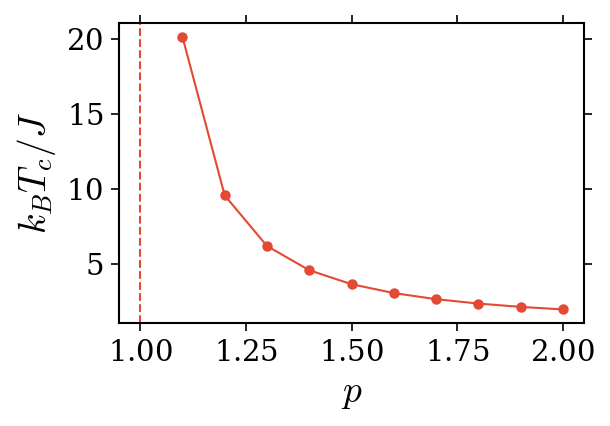

In [32]:
file_extrapol_graph = os.path.join(path_save_graph,'Extrapolation',file_name_base+'_all_p.png')
# data 
x_data = df_extrapol_val.columns.map(lambda x: float(x.replace('P',''))).values
x_data = np.delete(x_data,1) # clear 1.05
y_data = 1/df_extrapol_val.loc['infty'].values
y_data = np.delete(y_data,1) # clear 1.05
# # data for squared 
# y_data = np.sqrt(y_data)

# Load the default style.
style.use("default")
rcParams["text.usetex"] = False

fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
grid_spec = GridSpec(3, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])

ax.plot(x_data, y_data, marker="o", lw=1)

ax.set_xlabel(r"$p$")
ax.set_ylabel(r"$k_BT_c/J$")
ax.axvline(x=1,linestyle='--')

pyplot.draw()

# print('Save graph {}'.format(file_extrapol_graph))
# pyplot.savefig(file_extrapol_graph)

pyplot.show()